In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import seaborn as sns
from sklearn.preprocessing import normalize
import pyreadr
import igraph as ig
PATH = '../Data/Data/'

In [4]:
id_col = pd.read_csv(PATH + 'icd_colors.csv', index_col=0)

In [5]:
letter_to_hex = {row['Letter']: hex_code for hex_code, row in id_col.iterrows()}

In [6]:
icd_10_diag_all = pd.read_csv('./../../Comorbidity-Networks-From-Population-Wide-Health-Data/ICD10_Diagnoses_All.csv')

In [7]:
label_all_code = list(icd_10_diag_all['icd_code'])

In [9]:
prev = pd.read_excel(PATH + 'Prevalence_Sex_Age_ICD.xlsx', index_col=0)

In [10]:
mort_m = pd.read_csv(PATH + 'mortality_diag_Male.csv', index_col=0)
mort_f = pd.read_csv(PATH + 'mortality_diag_Female.csv', index_col=0)

In [11]:
mort_M = np.zeros((8,1080))
mort_F = np.zeros((8,1080))

for i in range(8):
    for j in range(1080):
        n_i = i
        n_j = j
        i+1
        val = mort_m.loc[(mort_m['age_10'] == i) & (mort_m['icd_code'] == label_all_code[j]), 'mortality'].values
        val_f = mort_f.loc[(mort_f['age_10'] == i) & (mort_f['icd_code'] == label_all_code[j]), 'mortality'].values
        if len(val_f) > 0:
            mort_F[n_i, n_j] = val_f[0]
        else:
            mort_F[n_i, n_j] = 0.0
        if len(val) > 0:
            mort_M[n_i, n_j] = val[0]
        else:
            mort_M[n_i, n_j] = 0.0
        # prev_m[c, :] = prev.loc[(prev.index == 'Male') & (prev['Age_Group'] == i), 'p'].values

        

In [12]:
age_groups = ['0-9', '10-19',  '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
prev_f = np.zeros((8, 1080))
prev_m = np.zeros((8, 1080))

for n_i, i in enumerate(age_groups):
    for n_j, j in enumerate(label_all_code):
        # Select the 'p' values where 'sex' is 'Female' and 'Age_Group' matches i
        val = prev.loc[(prev.index == 'Female') & (prev['Age_Group'] == i) & (prev['icd_code'] == j), 'p'].values
        val_m = prev.loc[(prev.index == 'Male') & (prev['Age_Group'] == i) & (prev['icd_code'] == j), 'p'].values
        if len(val_m) > 0:
            prev_m[n_i, n_j] = val_m[0]
        else:
            prev_m[n_i, n_j] = 0.0
        if len(val) > 0:
            prev_f[n_i, n_j] = val[0]
        else:
            prev_f[n_i, n_j] = 0.0
        # prev_m[c, :] = prev.loc[(prev.index == 'Male') & (prev['Age_Group'] == i), 'p'].values


## Age and Sex Analysis

In [ ]:
number_of_rows = 16
properties = pd.DataFrame({
    'Age': list(range(1, 9)) * 2,
    'sex': [None] * number_of_rows,
    'nodes': [None] * number_of_rows,
    'degree': [None] * number_of_rows,
    'avg_path_length': [None] * number_of_rows,
    'betweenness': [None] * number_of_rows,
    'cen_ftrality': [None] * number_of_rows,
    'closeness': [None] * number_of_rows,
    'density': [None] * number_of_rows,
    'modularity': [None] * number_of_rows
    
})

In [14]:
def normalize_matrix(OR_mat):
    # Loop over each row and normalize by row sums, avoiding division by zero
    for i in range(OR_mat.shape[0]):
        row_sum = OR_mat[i, :].sum()
        if row_sum > 0:
            OR_mat[i, :] = OR_mat[i, :] / row_sum
    return OR_mat

In [ ]:
OR_normalized = np.zeros((8, 1080, 1080))
OR_normalized_m = np.zeros((8, 1080, 1080))

ii=0
for age in range(1, 9):
    # Load adjacen_fcy matrix for males
    result = pyreadr.read_r(PATH+f"3.Adjacen_fcyMatrices/Adj_Matrix_Female_ICD_age_{age}.rds")
    result_f = pyreadr.read_r(PATH+f"3.Adjacen_fcyMatrices/Adj_Matrix_Male_ICD_age_{age}.rds")
    OR = result[None].values
    OR_f = result_f[None].values

    # Normalize adjacen_fcy matrix using the R-like method
    OR_f_normalized = normalize_matrix(OR_f.copy())
    OR_normalized_m[age-1,:,:] = OR_f_normalized
    
    # Normalize adjacen_fcy matrix using the R-like method
    OR_normalized[age-1,:,:] =  normalize_matrix(OR.copy())



In [40]:
cen_f =  np.zeros((1080, 8))
for i in range(8):

    cen_f[:, i] = np.sum(OR_normalized[i, :, :], axis=0)

cen_degree_f = np.zeros((1080, 8))
for i in range(8):
    cen_degree_f[:, i] = np.sum(np.where(OR_normalized[i, :, :]>0, 1, 0), axis=1)

cen_m =  np.zeros((1080, 8))
for i in range(8):
    cen_m[:, i] = np.sum(OR_normalized_m[i, :, :], axis=0)

cen_degree_m = np.zeros((1080, 8))
for i in range(8):
    cen_degree_m[:, i] = np.sum(np.where(OR_normalized_m[i, :, :]>0, 1, 0), axis=1)

In [41]:
# Create a label list with all the labels where cen_f.sum(1) > 0, from label_all_code
labels_nonzero = [label_all_code[i] for i in range(len(label_all_code)) if cen_f.sum(axis=1)[i] > 0]

In [17]:
mort_inf_f = np.zeros((1080, 8))
mort_inf_m = np.zeros((1080, 8))

mort_inf_degree_f = np.zeros((1080, 8))
mort_inf_degree_m = np.zeros((1080, 8))

# Calculate the mortality influence

for i in range(8):
    mult_matrix = OR_normalized[i, :, :] * mort_F[i, :, np.newaxis]
    mult_matrix_degree = np.where(OR_normalized[i, :, :] > 0, 1, 0) * mort_F[i, :, np.newaxis]
    mort_inf_degree_f[:, i] = (mult_matrix_degree - np.diag(np.diag(mult_matrix_degree))).sum(axis=0)
    mort_inf_f[:, i] = (mult_matrix - np.diag(np.diag(mult_matrix))).sum(axis=0)

for i in range(8):
    mult_matrix = OR_normalized_m[i, :, :] * mort_M[i, :, np.newaxis]
    mult_matrix_degree = np.where(OR_normalized_m[i, :, :] > 0, 1, 0) * mort_M[i, :, np.newaxis]
    mort_inf_degree_m[:, i] = (mult_matrix_degree - np.diag(np.diag(mult_matrix_degree))).sum(axis=0)
    mort_inf_m[:, i] = (mult_matrix - np.diag(np.diag(mult_matrix))).sum(axis=0)

In [ ]:
cen_f_betweeness_f = np.zeros((1080, 8))
cen_f_betweeness_m = np.zeros((1080, 8))

for i in range(8):
    # Compute betweenness cen_ftrality for each node from the weighted adjacen_fcy matrix
    g = ig.Graph.Weighted_Adjacen_fcy(OR_normalized[i, :, :].tolist(), mode="max", attr="weight")
    betweenness = g.betweenness(weights="weight")
    cen_f_betweeness_f[:, i] = betweenness
    g_m = ig.Graph.Weighted_Adjacen_fcy(OR_normalized_m[i, :, :].tolist(), mode="max", attr="weight")
    betweenness_m = g_m.betweenness(weights="weight")
    cen_f_betweeness_m[:, i] = betweenness_m

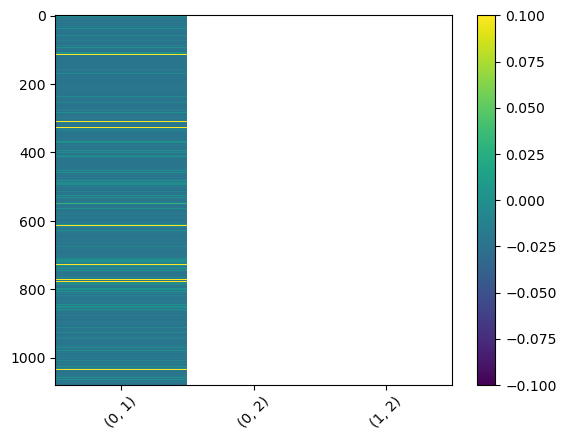

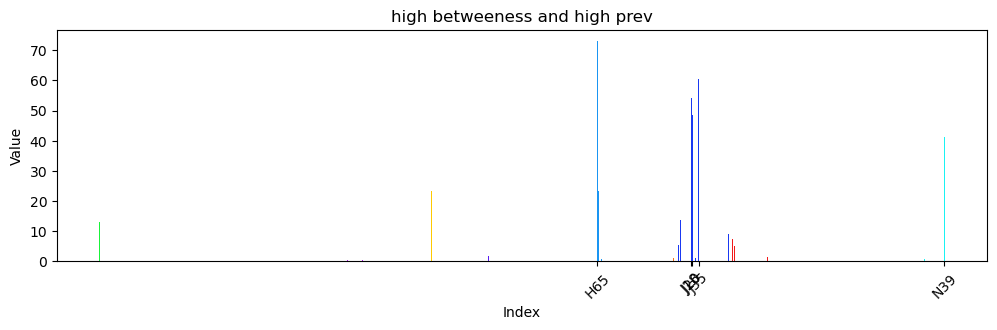

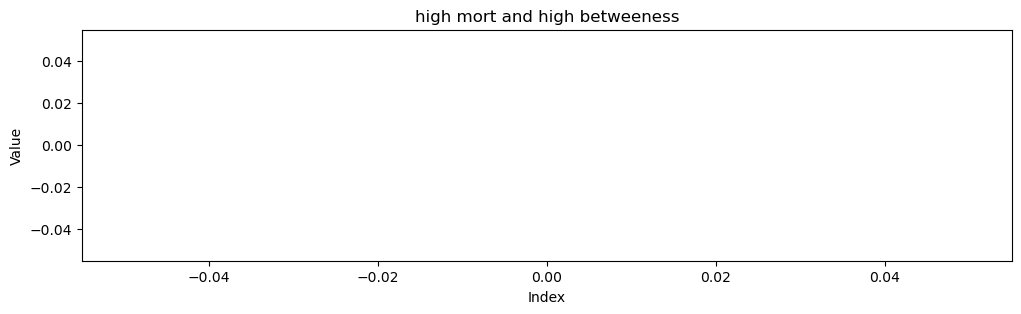

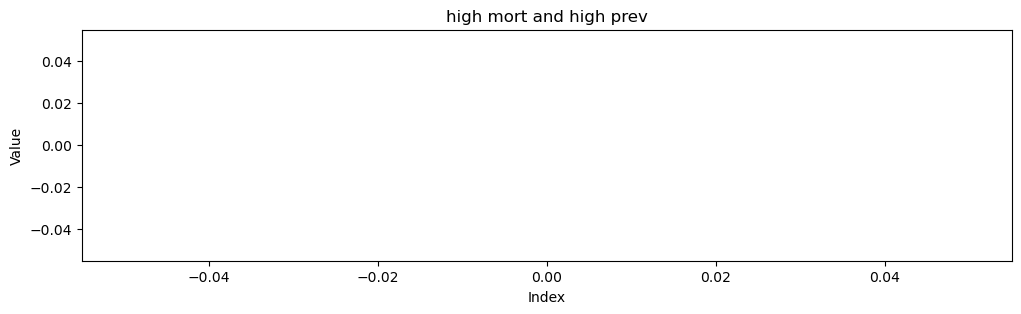

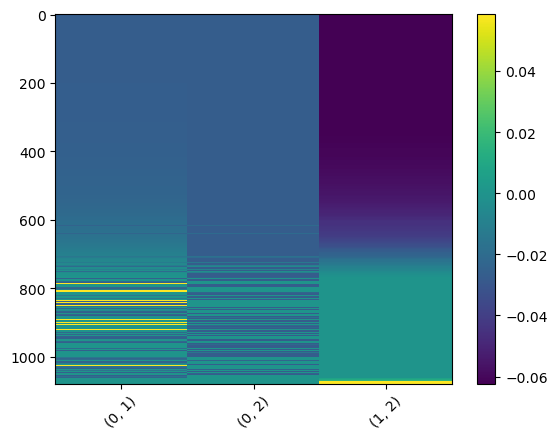

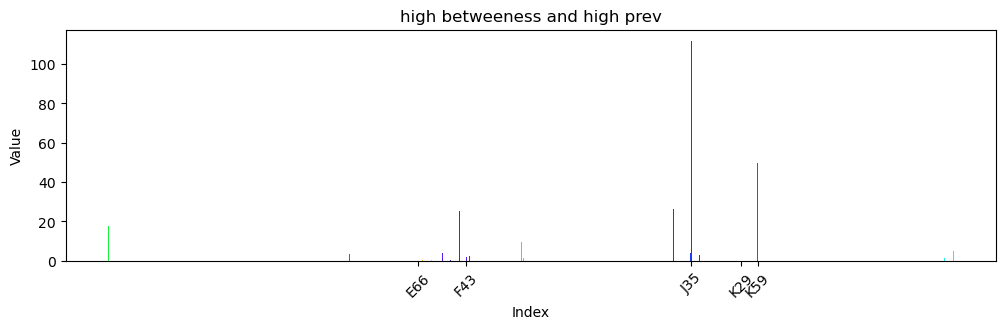

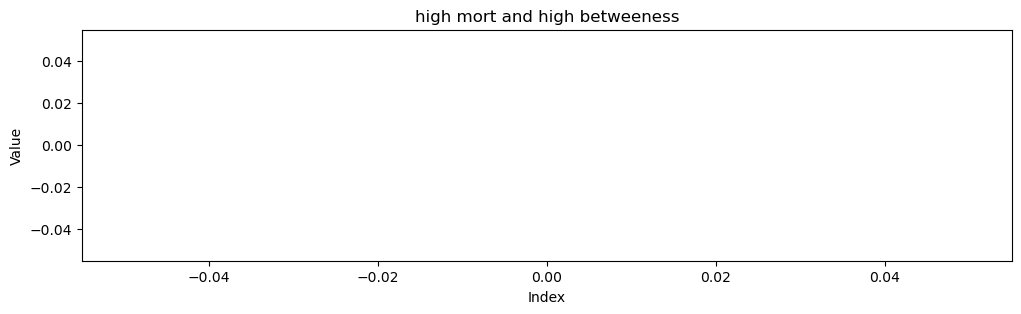

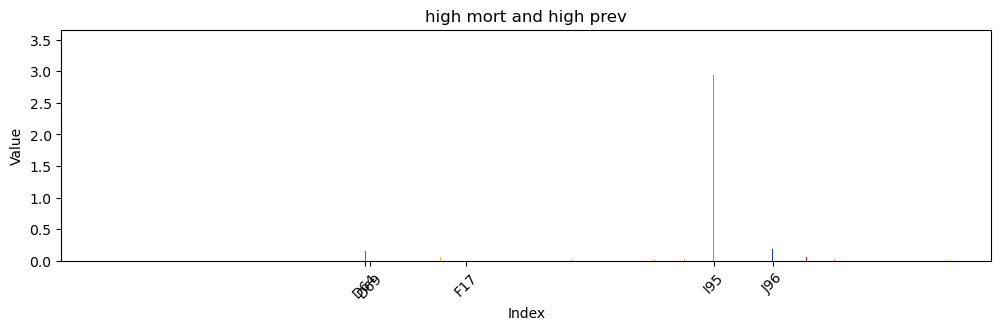

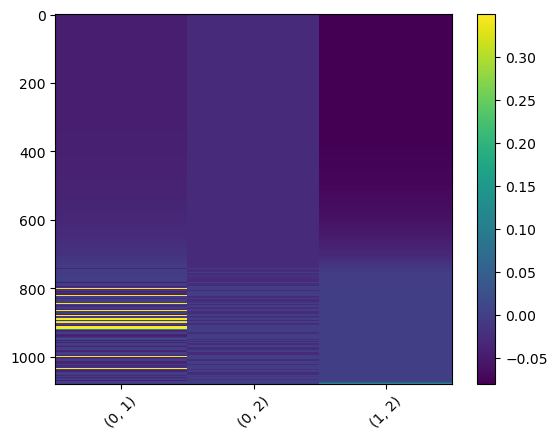

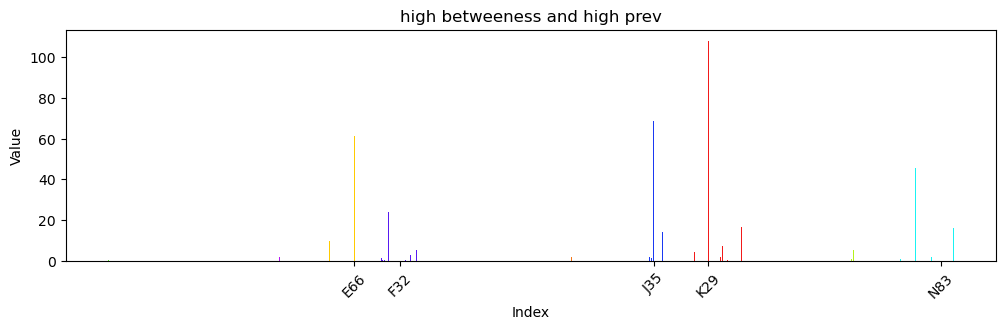

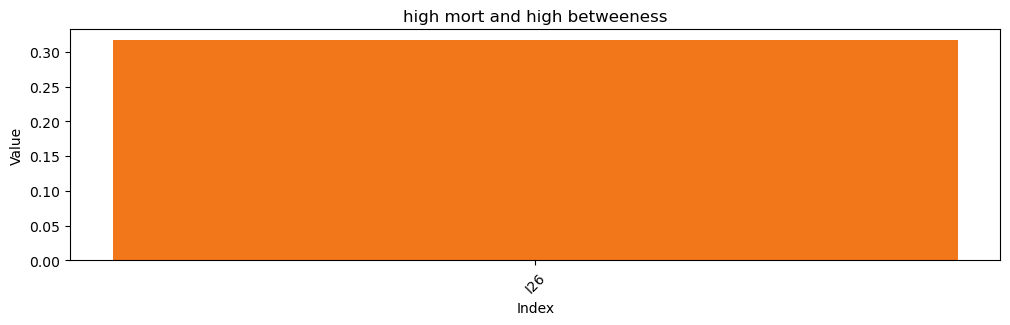

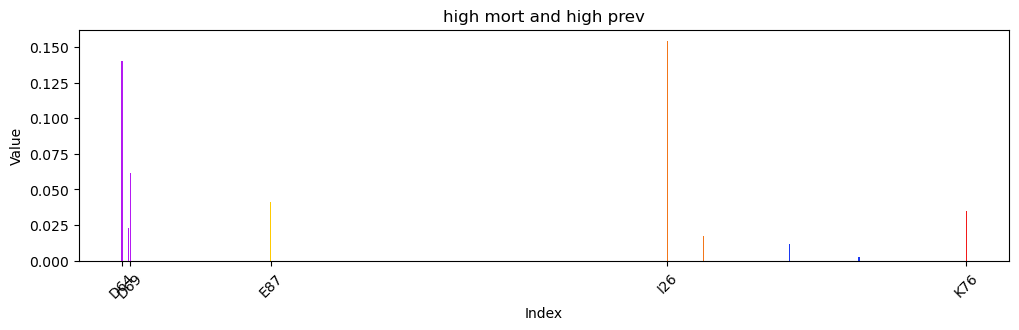

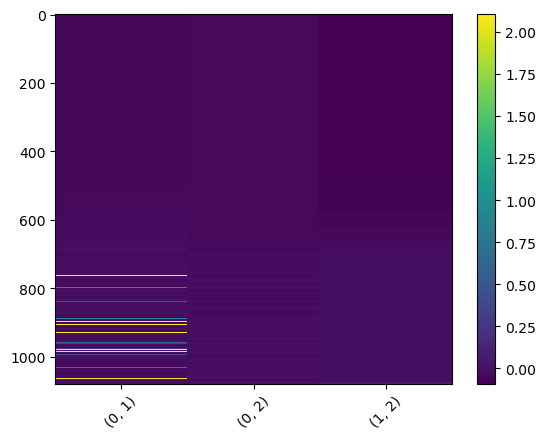

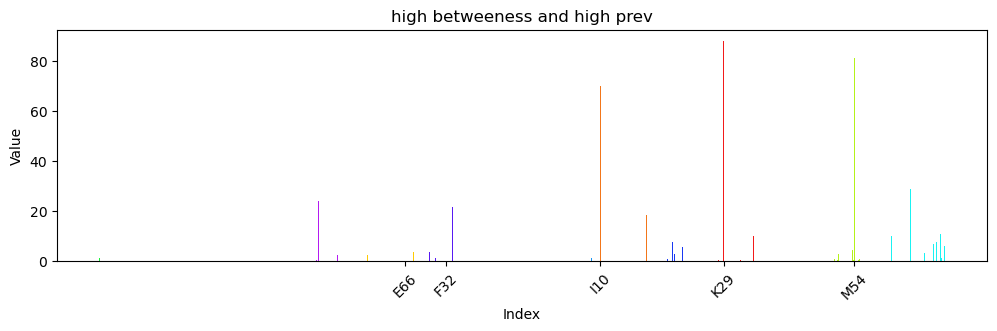

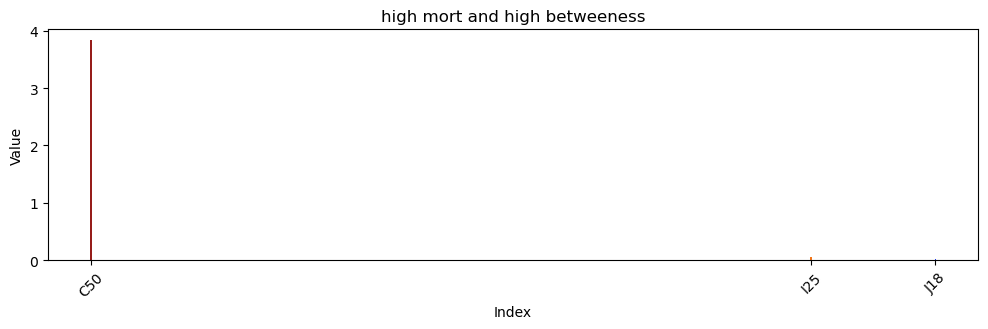

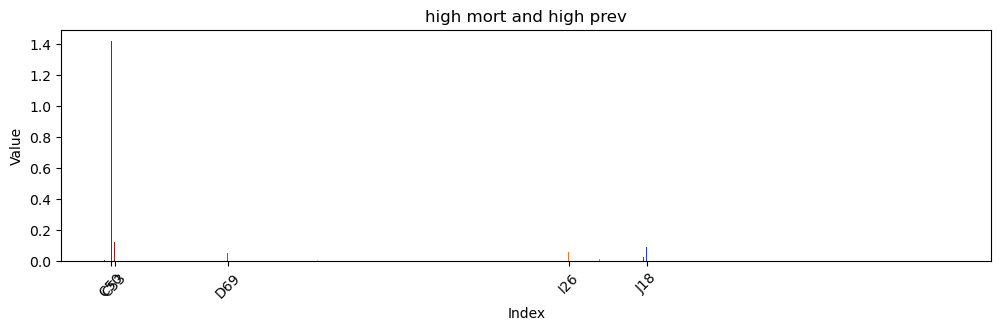

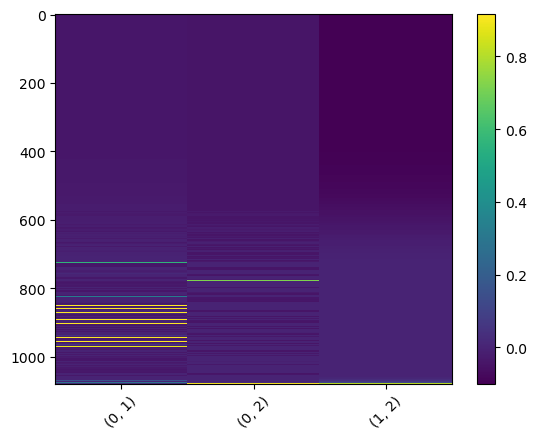

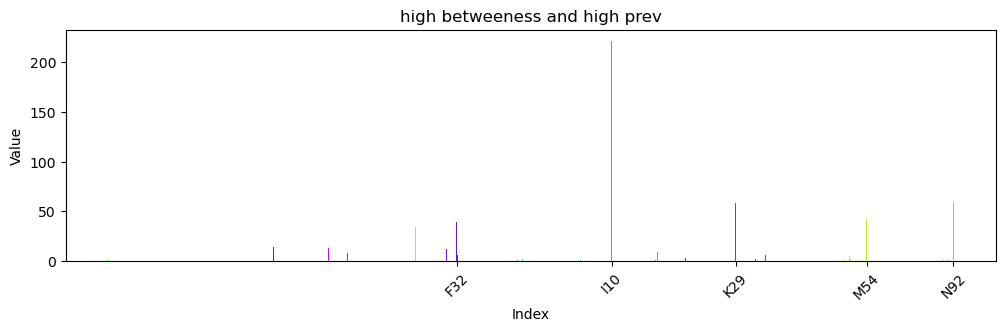

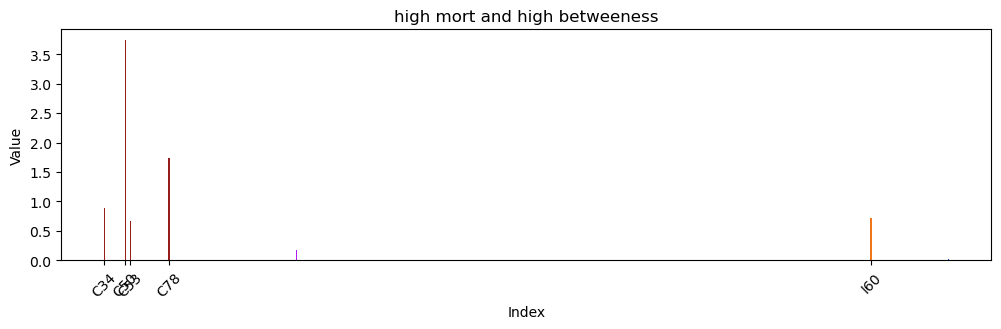

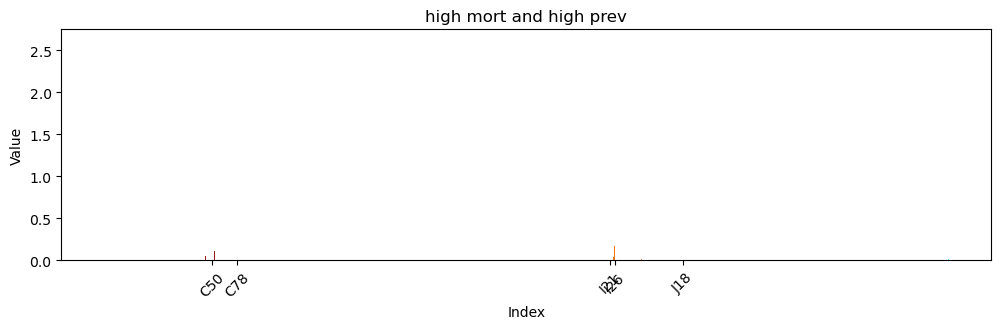

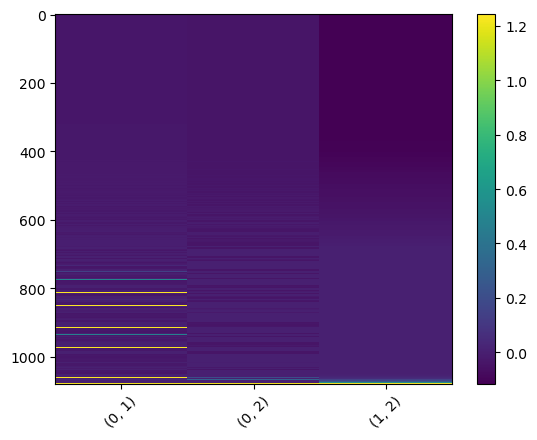

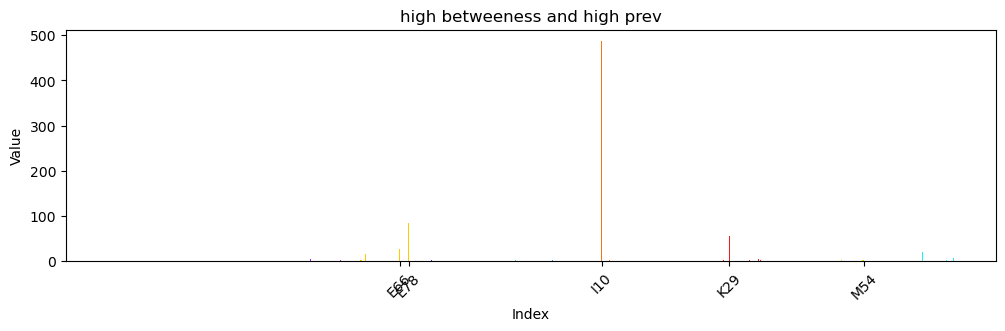

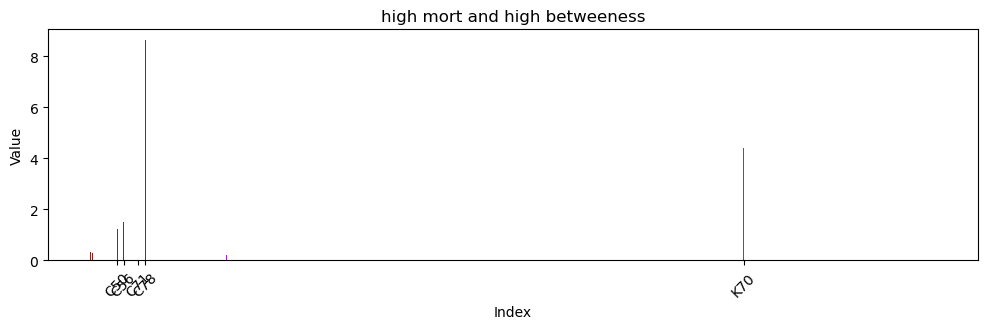

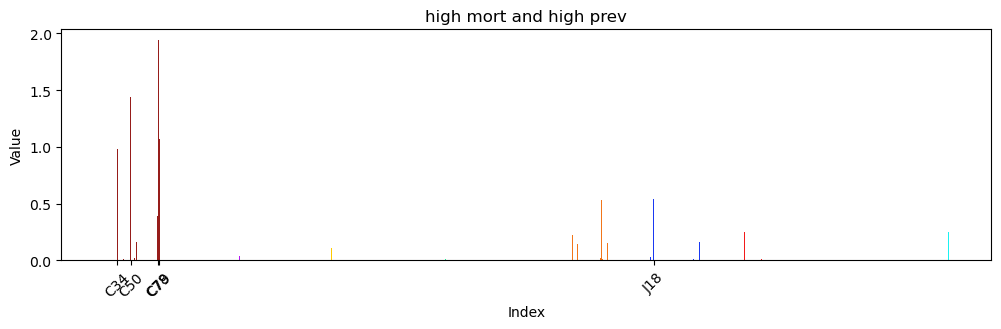

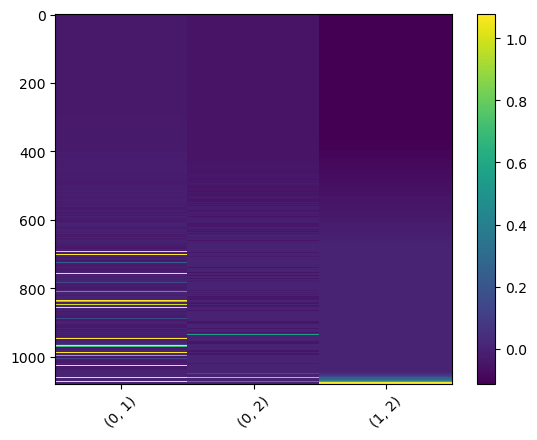

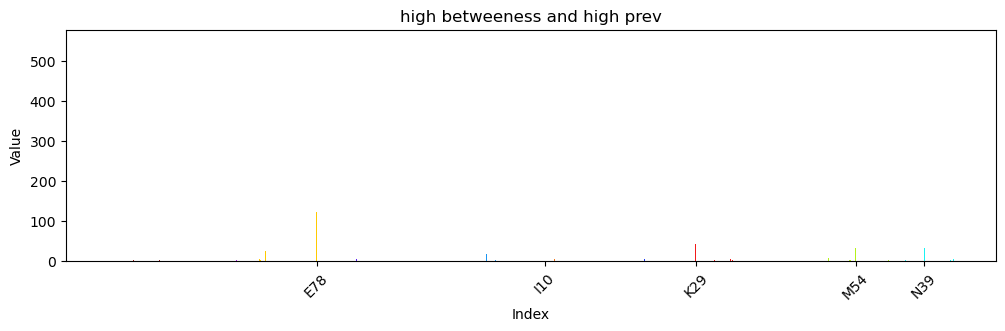

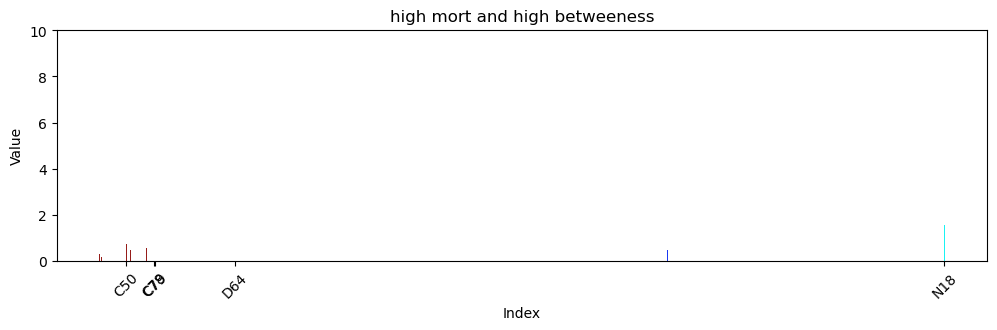

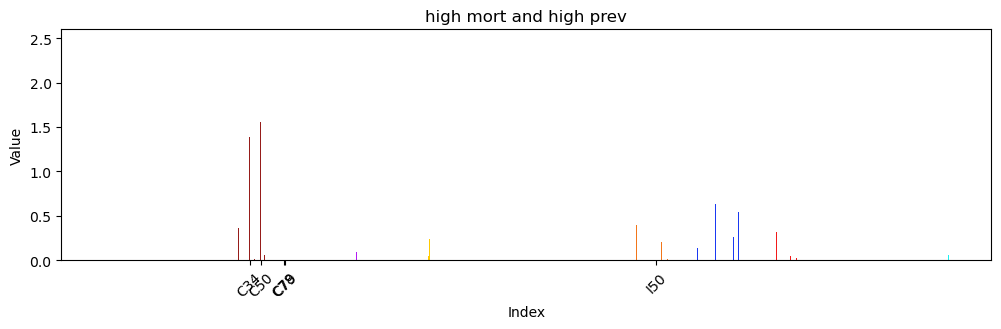

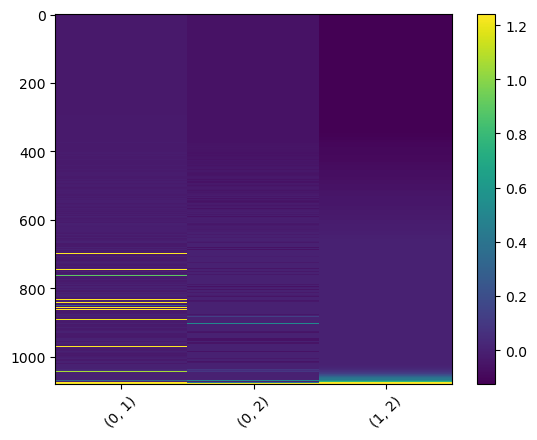

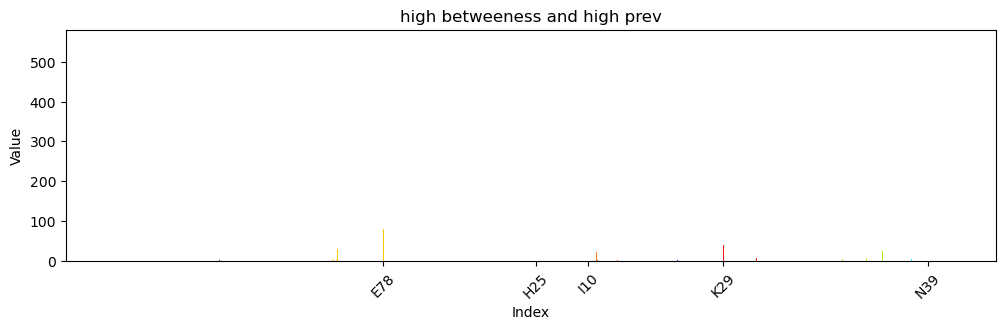

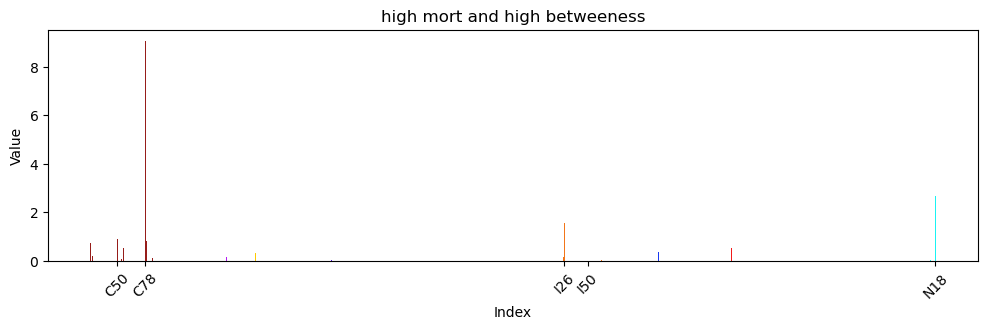

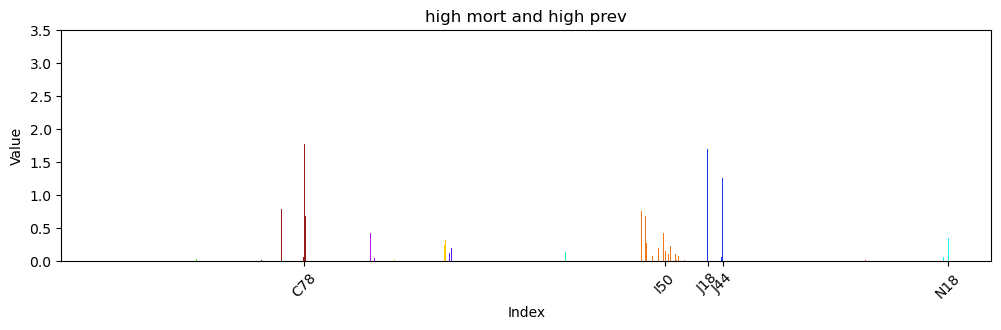

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from itertools import combinations
import scipy.stats

# Store cluster labels and cen_fters for each age group and sex
cluster_labels_f = []
cluster_cen_fters_f = []
cluster_labels_m = []
cluster_cen_fters_m = []

feature_names = ['cen_f', 'degree', 'betweenness', 'mort_inf', 'mort_inf_degree', 'prev', 'mort']

for i in range(8):
    features_f = np.stack([
        #cen_f_f[:, i],
        #cen_f_degree_f[:, i],
        cen_f_betweeness_f[:, i],
        #mort_inf_f[:, i],
        #mort_inf_degree_f[:, i],
        prev_f.T[:, i],
        mort_F.T[:, i]
    ], axis=1)
    features_m = np.stack([
        #cen_f_m[:, i],
        #cen_f_degree_m[:, i],
        cen_f_betweeness_m[:, i],
        #mort_inf_m[:, i],
        #mort_inf_degree_m[:, i],
        prev_m.T[:, i],
        mort_M.T[:, i]
    ], axis=1)
    
    import matplotlib.pyplot as plt

    features_f = scipy.stats.zscore(features_f, axis=0)
    features_m = scipy.stats.zscore(features_m, axis=0)



    # Compute all pairwise products between different features (off-diagonal)

    n_features = features_f.shape[1]
    pair_indices = list(combinations(range(n_features), 2))  # 21 pairs

    # For each row, compute all pairwise products
    features_f_pairwise = np.empty((features_f.shape[0], len(pair_indices)*2))
    for idx, (i, j) in enumerate(pair_indices):
        features_f_pairwise[:, idx] = features_f[:, i] * features_f[:, j] * np.sign(np.sign(features_f[:, i]) + np.sign(features_f[:, j]))  # product of features, with sign
        features_f_pairwise[:, idx + len(pair_indices)] = features_f[:, j] * features_f[:, i] *  np.sign(np.sign(features_f[:, j]) + np.sign(features_f[:, i]))  # product of features, with sign

    # If you want only unique products (i<j), use only the first 21 columns:
    features_f_pairwise = features_f_pairwise[:, :len(pair_indices)]

    order = np.argsort(features_f_pairwise[:,-1])

    plt.imshow(features_f_pairwise[order,:], aspect='auto', interpolation='none', vmin = np.percen_ftile(features_f_pairwise, 10), vmax = np.percen_ftile(features_f_pairwise, 99))

    plt.xticks(np.arange(3), pair_indices, rotation = 45)
    plt.colorbar()
    plt.show()
    plt.close()

    mask = np.where(features_f_pairwise.mean(1) > 0, True, False)

    label = ['high betweeness and high prev', 'high mort and high betweeness', 'high mort and high prev']
    for j in range(3):
        vals = features_f_pairwise[:, j]
        pos_idx = np.where(vals > 0)[0]
        colors = [letter_to_hex[label_all_code[n][0]] for n in pos_idx]

        plt.figure(figsize=(12, 3))
        plt.bar(pos_idx, vals[pos_idx], color=colors)
        plt.title(label[j])
        # Show only the top 5 bars if there are at least 5
        top_n = min(5, len(pos_idx))
        if top_n > 0:
            top_indices = np.argsort(vals[pos_idx])[-top_n:]  # indices of top 5 values
            top_pos_idx = pos_idx[top_indices]
            top_vals = vals[top_pos_idx]
            top_colors = [colors[i] for i in top_indices]
            plt.bar(top_pos_idx, top_vals, color=top_colors)
            plt.xticks(top_pos_idx, [f"{label_all_code[j]}" for j in top_pos_idx], rotation=45)

        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.show()

    # features_f_pairwise now has shape (1080, 21)

    # If you want all ordered pairs (i != j), use:
    # features_f_pairwise_full = np.empty((features_f.shape[0], n_features*(n_features-1)))
    # idx = 0
    # for i in range(n_features):
    #     for j in range(n_features):
    #         if i != j:
    #             features_f_pairwise_full[:, idx] = features_f[:, i] * features_f[:, j]
    #             idx += 1
    # features_f_pairwise_full.shape  # (1080, 42)

    


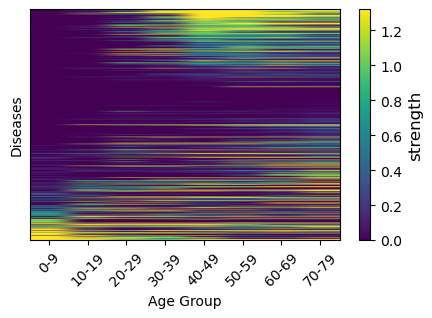

<Figure size 640x480 with 0 Axes>

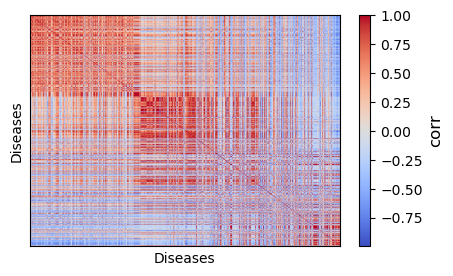

<Figure size 640x480 with 0 Axes>

In [31]:
# Select only rows in cen_f where the sum across columns is not zero
nonzero_cen_mask = cen_f.sum(axis=1) != 0
cen_nonzero = cen_f[nonzero_cen_f_mask, :]

# ICA on nonzero rows only
n_components_ica = 3  # You can change this as needed
ica_cen = FastICA(n_components=n_components_ica, random_state=0, max_iter=1000)
S_ica_cen = ica_cen.fit_transform(cen_nonzero)
order_ica_cen = np.argsort(S_ica_cen[:, 0])
cen_ica_ordered = cen_nonzero[order_ica_cen, :]

# Plot the reordered cen_f matrix
plt.figure(figsize=(5,3))
vmin_cen = np.percentile(cen_nonzero, 10)
vmax_cen = np.percentile(cen_nonzero, 90)
plt.imshow(cen_ica_ordered, cmap='viridis', aspect='auto', interpolation=None, vmin=vmin_cen, vmax=vmax_cen)
#plt.title('strength cen_ftrality over time')
plt.xticks(range(8), ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79'], rotation=45)
plt.xlabel('Age Group')
plt.yticks([])
plt.ylabel('Diseases')


cbar = plt.colorbar()
cbar.set_label('strength', fontsize=12)
plt.show()
plt.savefig('./../Figures/cen_f_ica_ordered_overtime.png', dpi=600, bbox_inches='tight')

# Compute and plot the correlation matrix of the reordered cen_f
corr_cen_ica = np.corrcoef(cen_ica_ordered)
plt.figure(figsize=(5,3))
plt.imshow(corr_cen_ica, cmap='coolwarm', aspect='auto')
plt.xticks([])
plt.yticks([])
plt.xlabel('Diseases')
plt.ylabel('Diseases')
#plt.title('Correlation Matrix of ICA-Ordered cen_f (nonzero rows)')
cbar = plt.colorbar()
cbar.set_label('corr', fontsize=12)
plt.show()
plt.savefig('./../Figures/corr_cen_f_ica_ordered.png', dpi=600, bbox_inches='tight')

c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


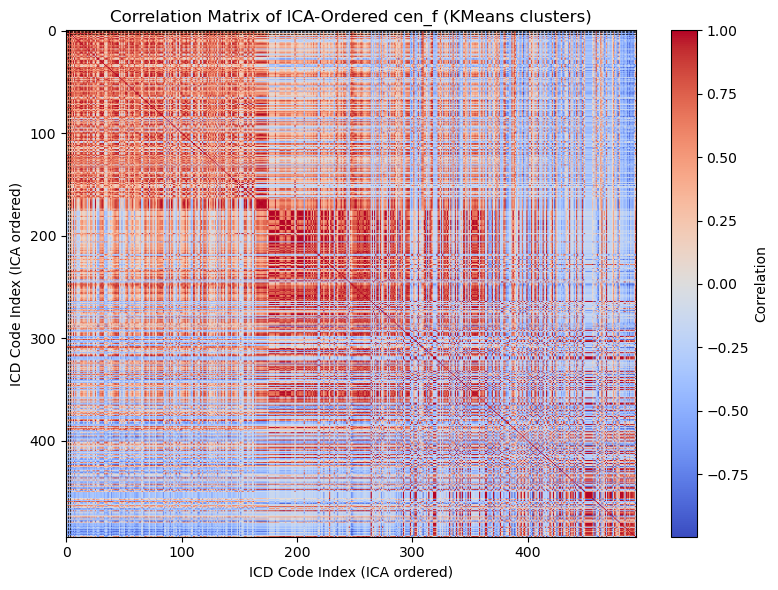

Cluster 0: 284 elements
Cluster 1: 88 elements
Cluster 2: 122 elements


In [33]:
from sklearn.cluster import KMeans

# Choose the number of clusters (e.g., 4, but you can adjust)
n_clusters = 3
corr_cen_f_nonzero = np.corrcoef(cen_nonzero)

# Perform k-means clustering on the correlation matrix of ICA-ordered cen_f
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
labels_kmeans = kmeans.fit_predict(corr_cen_f_nonzero)

# Plot the reordered correlation matrix with cluster labels
plt.figure(figsize=(8, 6))
plt.imshow(corr_cen_ica, cmap='coolwarm', aspect='auto')
plt.title('Correlation Matrix of ICA-Ordered cen_f (KMeans clusters)')
plt.colorbar(label='Correlation')
plt.xlabel('ICD Code Index (ICA ordered)')
plt.ylabel('ICD Code Index (ICA ordered)')

# Optionally, show cluster boundaries
for c in range(n_clusters):
    idx = np.where(labels_kmeans == c)[0]
    if len(idx) > 0:
        plt.axhline(idx[0], color='k', linestyle='--', linewidth=0.5)
        plt.axvline(idx[0], color='k', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

# Show cluster sizes
for c in range(n_clusters):
    print(f"Cluster {c}: {np.sum(labels_kmeans == c)} elements")

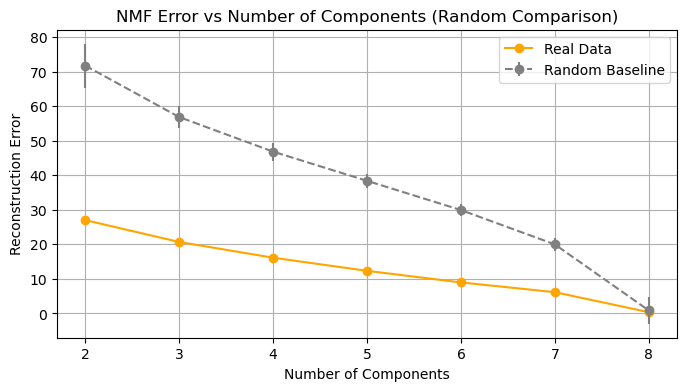

In [34]:
from sklearn.decomposition import NMF

component_range = range(2, 9)
reconstruction_errors = []
random_errors_mean = []
random_errors_std = []

n_random = 200 # Number of random permutations

for n in component_range:
    # Fit NMF to real data
    nmf_model = NMF(n_components=n, init='random', random_state=0, max_iter=1000)
    W_tmp = nmf_model.fit_transform(np.abs(cen_nonzero))
    error = nmf_model.reconstruction_err_
    reconstruction_errors.append(error)
    
    # Fit NMF to randomly permuted data
    rand_errs = []
    for _ in range(n_random):
        cen_shuffled = np.abs(cen_nonzero).copy().flatten()
        np.random.shuffle(cen_shuffled)
        cen_shuffled = cen_shuffled.reshape(cen_nonzero.shape)
        nmf_rand = NMF(n_components=n, init='random', random_state=None, max_iter=1000)
        nmf_rand.fit(cen_shuffled)
        rand_errs.append(nmf_rand.reconstruction_err_)
    random_errors_mean.append(np.mean(rand_errs))
    random_errors_std.append(np.std(rand_errs))
    

plt.figure(figsize=(8, 4))
plt.plot(component_range, reconstruction_errors, marker='o', label='Real Data', color='orange')
plt.errorbar(component_range, random_errors_mean, yerr=random_errors_std, fmt='--o', label='Random Baseline', color='gray')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('NMF Error vs Number of Components (Random Comparison)')
plt.legend()
plt.grid(True)
plt.show()


c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

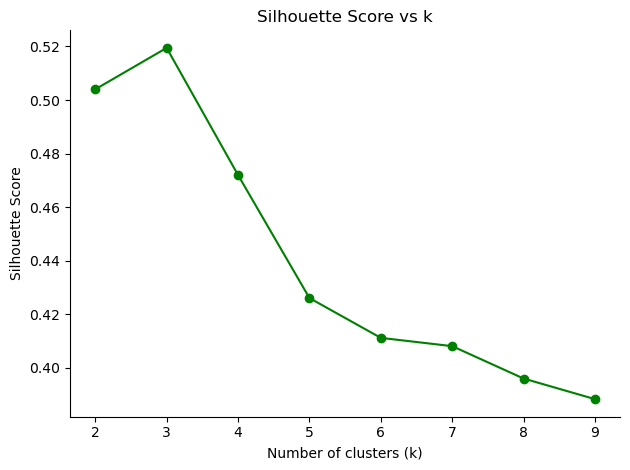

Best k (clusters) according to silhouette score and literature: 2


c:\Users\matte\anaconda3\envs\base_m\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [35]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different values of k (number of clusters)
k_range = range(2, 10)
inertia = []
silhouette = []

corr_cen_nonzero = np.corrcoef(cen_nonzero)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(corr_cen_nonzero)
    inertia.append(kmeans.inertia_)
    # Compute silhouette score only if k > 1 and less than number of samples
    if 1 < k < corr_cen_ica.shape[0]:
        sil = silhouette_score(corr_cen_nonzero, labels)
    else:
        sil = np.nan
    silhouette.append(sil)

"""BaseExceptionplt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('KMeans Inertia vs k')
plt.grid(True)"""

plt.plot(k_range, silhouette, marker='o', color='green')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# According to literature, 3-6 clusters are often used for disease network modules.
# Choose the k with the highest silhouette score in this range
best_k = k_range[np.nanargmax(silhouette[1:6])]   # 3-6 clusters
print(f"Best k (clusters) according to silhouette score and literature: {best_k}")

# Fit KMeans with the best k
kmeans_best = KMeans(n_clusters=best_k, random_state=0, n_init=10)
labels_best = kmeans_best.fit_predict(corr_cen_f_nonzero)



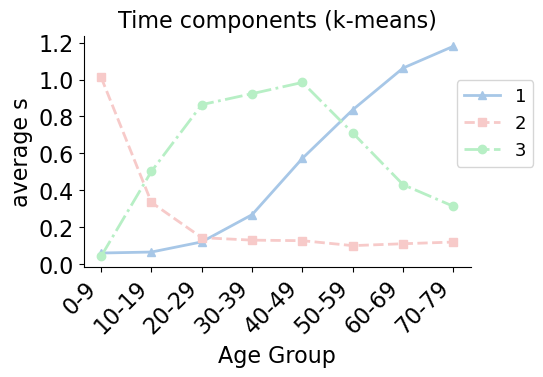

In [38]:
from sklearn.decomposition import PCA

# Plot the evolution of the three clusters (from KMeans) over time (age groups)
# For each cluster, compute the mean value of cen_f_ica_ordered for all ICD codes in that cluster at each age group
labels_age = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
fsize= 6
plt.figure(figsize=(5, 3))
fsize = 16  # or your preferred fontsize
line_styles = ['-', '--', '-.']  # Three different line styles
# Three very soft pastel colors (e.g., light blue, light pink, light green)
colors = ['#A7C7E7', '#F7CAC9', '#B7EFC5']
markers = ['^', 's', 'o'] 

       # Triangle, square, circle markers
for c in range(n_clusters):
    idx = np.where(labels_kmeans == c)[0]
    cluster_mean = cen_nonzero[idx, :].mean(axis=0)
    plt.plot(
        range(1, cen_nonzero.shape[1] + 1),
        cluster_mean,
        label=f'{c+1}',
        linestyle=line_styles[c % len(line_styles)],
        marker=markers[c % len(markers)],
        linewidth=2,
        color=colors[c]
    )
    cluster_mean = cen_nonzero[idx, :].mean(axis=0)
    
plt.xlabel('Age Group', fontsize=fsize)
plt.ylabel('average s', fontsize=fsize)
plt.title('Time components (k-means)', fontsize=fsize)
plt.xticks(
    ticks=np.arange(1, cen_nonzero.shape[1] + 1),
    labels=labels_age,
    rotation=45,
    fontsize=fsize,
    ha='right'
)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize-3, loc='center left', bbox_to_anchor=(0.94, 0.62))
# Remove grid from background
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('./../Figures/time_components_kmeans.png', dpi=600, bbox_inches='tight')
plt.show()



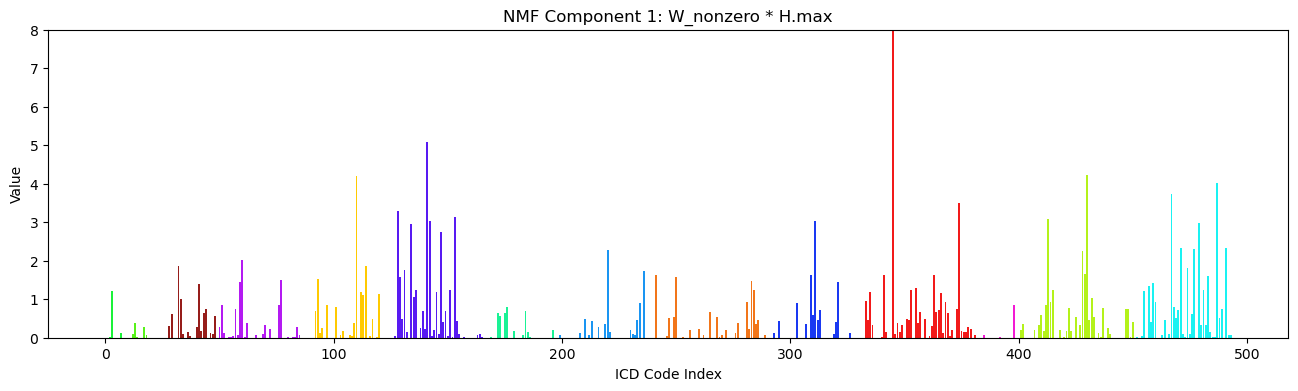

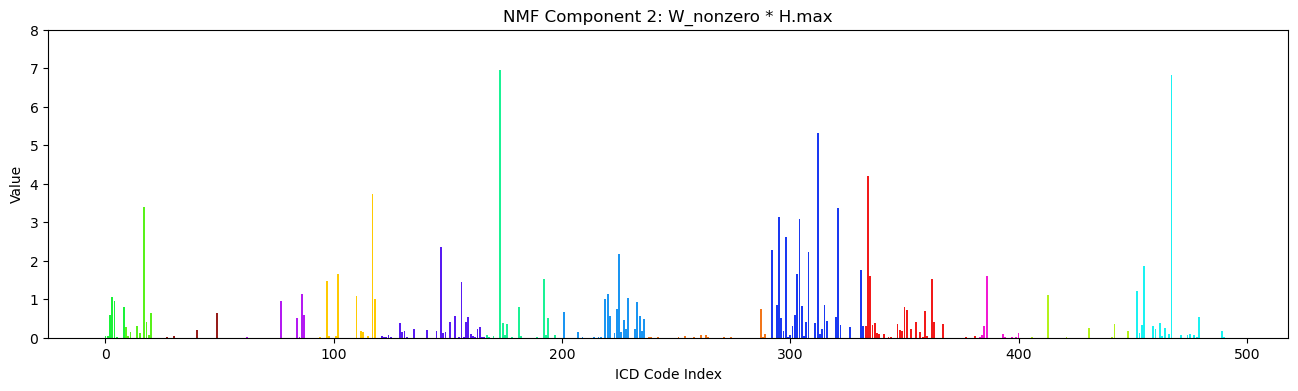

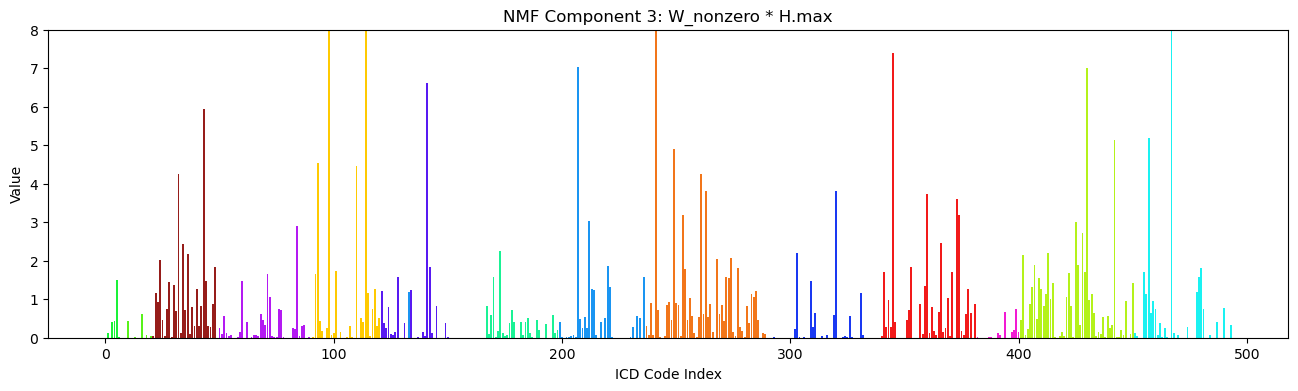

In [45]:
from sklearn.decomposition import NMF

# NMF with 3 components on x_valid vs y_valid (or any matrix, here let's use cen_f_nonzero as in previous context)
n_components = 3
nmf_model = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)
W_nmf = nmf_model.fit_transform(np.abs(cen_nonzero))
H_nmf = nmf_model.components_

# For each component, plot W_nonzero[:, i] * H_nmf.max() with color by ICD group
for i in range(n_components):
    plt.figure(figsize=(16, 4))
    values = W_nmf[:, i] * H_nmf[i].max()
    # Get colors for all bars
    all_colors = [letter_to_hex[labels_nonzero[n][0]] for n in range(len(values))]
    plt.bar(range(len(values)), values, color=all_colors)
    plt.title(f'NMF Component {i+1}: W_nonzero * H.max')
    plt.xlabel('ICD Code Index')
    plt.ylabel('Value')
    plt.ylim([0, 8])  # Set y-limits to 10% above max value
    plt.show()

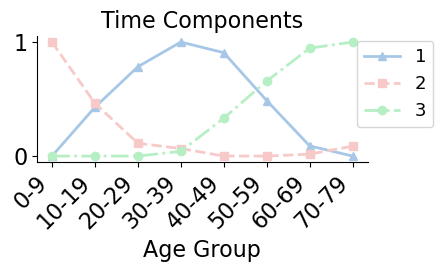

In [ ]:
# Plot the three dimensions of H_nmf (NMF components over age groups)
plt.figure(figsize=(5, 3))
fsize = 16
line_styles = ['-', '--', '-.']
colors = ['#A7C7E7', '#F7CAC9', '#B7EFC5']
markers = ['^', 's', 'o']
labels_age = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

for i in range(H_nmf.shape[0]):
    plt.plot(
        range(1, H_nmf.shape[1] + 1),
        H_nmf[i]/max(H_nmf[i]),  # Normalize each component to its max
        label=f'{i+1}',
        linestyle=line_styles[i % len(line_styles)],
        marker=markers[i % len(markers)],
        linewidth=2,
        color=colors[i % len(colors)]
    )

plt.xlabel('Age Group', fontsize=fsize)
plt.ylabel('', fontsize=fsize)
plt.title('Time Components', fontsize=fsize)
plt.xticks(
    ticks=np.arange(1, H_nmf.shape[1] + 1),
    labels=labels_age,
    rotation=45,
    fontsize=fsize,
    ha='right'
)
plt.yticks(fontsize=fsize)
plt.legend(fontsize=fsize-3, loc='cen_fter left', bbox_to_anchor=(0.94, 0.62))
plt.grid(False)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
